In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import logging
import os

import numpy as np
import pandas as pd

import core.config as cconfig
import core.signal_processing as csigproc
import core.statistics as costatis
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hpandas as hpandas
import helpers.hparquet as hparque
import helpers.hprint as hprint

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-332774b4-a276-4491-951f-2d0abeb32540.json'
INFO  # Git
  branch_name='CmampTask8631_Add_cross_correlation_to_regression_notebook'
  hash='047057b48'
  # Last commits:
    * 047057b48 paul     Checkpoint                                                        (12 minutes ago) Tue Jun 18 13:07:54 2024  (HEAD -> CmampTask8631_Add_cross_correlation_to_regression_notebook, origin/CmampTask8631_Add_cross_correlation_to_regression_notebook)
    * b8e50c776 paul     Checkpoint                                                        (    4 days ago) Fri Jun 14 20:26:16 2024           
    * 6e45e982f paul     Checkpoint                                                        (    4 days ago) Fri Jun 14 20:14:48 2024           
# Machine info
  system=Linux
  node name=6ecb40d594d2
  release=5.15.0-1058-aws
  version=#64~20.04.1-Ubuntu SMP Tue Apr 9 11:12:27 UTC 2024
  machine=x86_64
  

# Build config

In [4]:
amp_dir = hgit.get_amp_abs_path()
dir_name = os.path.join(
    amp_dir,
    "/shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.60T.2023-08-01_2024-01-31.ins.run0/tiled_results",
)
cols = [
    "p1.c",
    "p2.c",
    "p_lr.c",
    "q1.c",
    "q2.c",
    "q3.c",
    "r1.c",
    "r2.c",
    "r4.c",
    "r5.c",
    "r6.c",
    "r_lr.c",
    "v_ld.c",
]

config = {
    "dir_name": dir_name,
    "asset_id_col": "asset_id",
    "feature_col_names": cols,
    "price_col_name": "close",
    "regression_config": {
        "x_cols": cols,
        "x_col_shift": 1,
    },
    "cross_correlation_config": {
        "first_lag": 1,
        "last_lag": 5,
    }
}
config = cconfig.Config().from_dict(config)
print(config)

ERROR While executing 'get_extra_amp_repo_sym_name()' caught error:
name 'get_extra_amp_repo_sym_name' is not defined
Trying to continue
dir_name: /shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.60T.2023-08-01_2024-01-31.ins.run0/tiled_results
asset_id_col: asset_id
feature_col_names: ['p1.c', 'p2.c', 'p_lr.c', 'q1.c', 'q2.c', 'q3.c', 'r1.c', 'r2.c', 'r4.c', 'r5.c', 'r6.c', 'r_lr.c', 'v_ld.c']
price_col_name: close
regression_config: 
  x_cols: ['p1.c', 'p2.c', 'p_lr.c', 'q1.c', 'q2.c', 'q3.c', 'r1.c', 'r2.c', 'r4.c', 'r5.c', 'r6.c', 'r_lr.c', 'v_ld.c']
  x_col_shift: 1
cross_correlation_config: 
  first_lag: 1
  last_lag: 5


# Report tile metadata

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1020313424,2,6,6,3.3 MB
1106736216,2,6,6,3.3 MB
1669260535,2,6,6,3.3 MB
1670436375,2,6,6,3.3 MB
1775391824,2,6,6,3.3 MB
1813442534,2,6,6,3.3 MB
1871387621,2,6,6,3.2 MB
2200033667,2,6,6,3.3 MB
2237530510,2,6,6,3.2 MB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids     size
year month                      
2023 8               25  13.8 MB
     9               25  13.4 MB
     10              25  13.8 MB
     11              25  13.3 MB
     12              25  13.8 MB
2024 1               25  13.7 MB

In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1020313424,
 1106736216,
 1669260535,
 1670436375,
 1775391824,
 1813442534,
 1871387621,
 2200033667,
 2237530510,
 2470395105,
 2499295598,
 2506553600,
 2565005155,
 2601760471,
 2971863517,
 2989693852,
 3304664847,
 3323452427,
 3326458212,
 4417972573,
 5141755262,
 6009830573,
 6335759645,
 8717633868,
 8968126878]

# Load features

In [9]:
asset_batch_size = len(asset_ids)
# Add the `asset_id_col` to also display the instruments. This is also required
# to make `yield_parquet_tiles_by_assets()` work.
requested_columns = [config["asset_id_col"]] + config["feature_col_names"]
tile_iter = hparque.yield_parquet_tiles_by_assets(
    config["dir_name"], asset_ids, config["asset_id_col"], asset_batch_size, None
)

In [10]:
tile = next(tile_iter)

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
feature_df = dtfmod.process_parquet_read_df(
    tile[config["feature_col_names"] + [config["asset_id_col"]]],
    config["asset_id_col"],
)
hpandas.df_to_str(feature_df, log_level=logging.INFO)

p1.c                                                                                                                                                                                                                                                                               p2.c                                                                                                                                                                                                                                                                             p_lr.c                                                                                                                                                                                                                                                                               q1.c                                                                                                                                                                                                                                                                               q2.c                                                                                                                                                                                                                                                                               q3.c                                                                                                                                                                                                                                                                               r1.c                                                                                                                                                                                                                                                                               r2.c                                                                                                                                                                                                                                                                               r4.c                                                                                                                                                                                                                                                                               r5.c                                                                                                                                                                                                                                                                               r6.c                                                                                                                                                                                                                                                                             r_lr.c                                                                                                                                                                                                                                                                             v_ld.c                                                                                                                                                                                                                                                                        
asset_id                  1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 250655360

# Generate target

In [12]:
asset_batch_size = len(asset_ids)
# Add the `asset_id_col` to also display the instruments. This is also required
# to make `yield_parquet_tiles_by_assets()` work.
requested_columns = [config["asset_id_col"]] + [config["price_col_name"]]
tile_iter = hparque.yield_parquet_tiles_by_assets(
    config["dir_name"], asset_ids, config["asset_id_col"], asset_batch_size, None
)

In [13]:
tile = next(tile_iter)

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
price_df = dtfmod.process_parquet_read_df(
    tile[[config["price_col_name"]] + [config["asset_id_col"]]],
    config["asset_id_col"],
)
hpandas.df_to_str(price_df, log_level=logging.INFO)

close                                                                                                                                                                                                                                                                        
asset_id                  1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878
2023-08-01 00:00:00+00:00      1.613     0.7648     1.7489      9.534     0.4415    0.11019     1225.1      12.15     23.716     161.19    0.08043      7.863     0.5876      7.546      0.978     0.7257      247.8     18.481     0.6317     1.8451     1.1689     2.3152      4.213     12.806     241.04
2023-08-01 01:00:00+00:00     1.6171     0.7638     1.7534      9.615     0.4432    0.11074     1236.4      12.23     23.908     161.78    0.08085      7.895     0.5966      7.586      0.985     0.7272     248.08     18.528      0.632     1.8529     1.1732      2.335      4.218     12.854     242.04
2023-08-01 02:00:00+00:00     1.5872     0.7643     1.7367      9.471     0.4365    0.10975     1218.5      12.12     23.557     161.67    0.08022      7.814     0.5986      7.534       0.97     0.7087     245.88     18.362     0.6257     1.8315     1.1585      2.269      4.183     12.758     241.14
                                 ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...
2024-01-31 21:00:00+00:00     2.9306     1.9457     4.3568     18.038     1.1576    0.15514     1970.8    115.533     98.003     164.28    0.09532     34.096     1.5077     15.397     2.6825     2.5516     234.66     24.568     1.5494     2.8324     1.7815     2.3155     11.582     34.436     300.66
2024-01-31 22:00:00+00:00     2.9058     1.9296     4.3525      17.85     1.1518     0.1543     1963.6    114.072     97.228     164.68    0.09456     33.714     1.4848       15.2     2.6548     2.5522     235.12     24.419     1.5464     2.8296     1.7627      2.297      11.45     33.757     300.57
2024-01-31 23:00:00+00:00     2.9127     1.9366     4.3777     17.844     1.1587    0.15426     1964.6    114.258     97.619     165.12    0.09487      33.73     1.5009     15.221     2.6688     2.5569     234.78     24.494     1.5484     2.8222     1.7659      2.306     11.477     33.566     301.17

In [15]:
rets_df = price_df.pct_change()
rets_df = rets_df.rename(mapper={"close": "rets"}, axis=1, level=0)
vol_df = rets_df.rolling(30).std()
zrets_df = csigproc.compress_tails(
    rets_df / vol_df.shift(config["regression_config"]["x_col_shift"]), 4
)
zrets_df = zrets_df.rename(mapper={"rets": "zrets"}, axis=1, level=0)

array([[<Axes: title={'center': 'zrets'}>]], dtype=object)

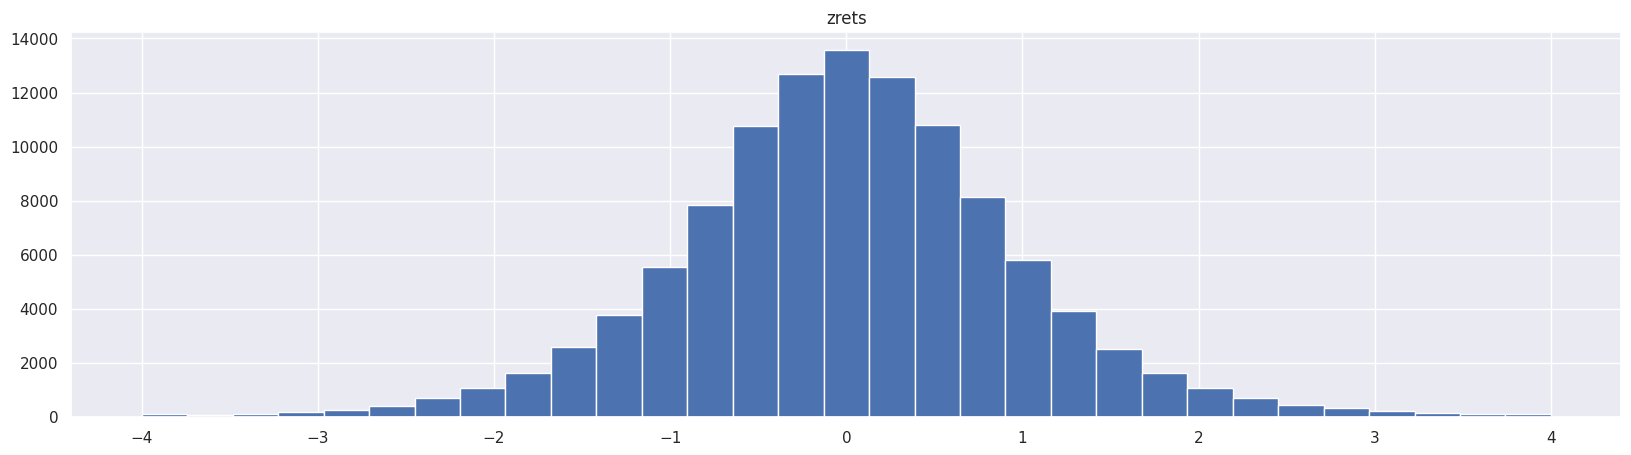

In [16]:
zrets_df.stack().hist(bins=31)

In [17]:
# Approximate total volatility in bps.
1e4 * vol_df.mean().mean()

93.21382094459739

In [18]:
# Approximate total vol in bps by asset.
1e4 * vol_df.mean().sort_values(ascending=False)

      asset_id  
rets  2200033667    161.641840
      6009830573    131.405226
      2971863517    112.971553
      3326458212    108.721338
      2565005155    106.290108
      2506553600    106.170354
      2989693852    105.451052
      1669260535    100.485251
      1775391824    100.468553
      2499295598     98.705587
      1670436375     96.798958
      1106736216     95.333454
      2237530510     94.821538
      6335759645     93.720530
      1020313424     93.671944
      4417972573     93.499866
      8717633868     89.277714
      5141755262     86.988835
      1813442534     81.865321
      2601760471     79.943809
      1871387621     69.042301
      3304664847     67.405211
      3323452427     63.452939
      2470395105     47.215165
      8968126878     44.997074
dtype: float64

# Combine features and target

In [19]:
regression_df = pd.concat([feature_df, zrets_df], axis=1)
hpandas.df_to_str(regression_df, log_level=logging.INFO)

p1.c                                                                                                                                                                                                                                                                               p2.c                                                                                                                                                                                                                                                                             p_lr.c                                                                                                                                                                                                                                                                               q1.c                                                                                                                                                                                                                                                                               q2.c                                                                                                                                                                                                                                                                               q3.c                                                                                                                                                                                                                                                                               r1.c                                                                                                                                                                                                                                                                               r2.c                                                                                                                                                                                                                                                                               r4.c                                                                                                                                                                                                                                                                               r5.c                                                                                                                                                                                                                                                                               r6.c                                                                                                                                                                                                                                                                             r_lr.c                                                                                                                                                                                                                                                                             v_ld.c                                                                                                                                                                                                                                                                              zrets                                                                                                                                                                                                                                                                        
asset_id                  1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 250655360

In [20]:
regression_coeffs = costatis.compute_regression_coefficients_by_group(
    regression_df,
    y_col="zrets",
    **config["regression_config"].to_dict(),
)
display(regression_coeffs.head())

Processing groups:   0%|          | 0/25 [00:00<?, ?it/s]

count  eff_count      mean       var     covar   sgn_rho       rho      beta  SE(beta)  beta_z_scored  p_val_2s  autocovar  autocorr      turn
1020313424 p1.c     4384     4384.0 -0.262329  1.873398 -0.017819 -0.030794 -0.013458 -0.009512  0.010674      -0.891062  0.372896   0.440061  0.234900  1.237012
           p2.c     4384     4384.0 -0.030376  1.098059 -0.016928 -0.046761 -0.016700 -0.015417  0.013943      -1.105719  0.268848  -0.041967 -0.038220  1.440985
           p_lr.c   4384     4384.0 -0.148417  1.597772 -0.022956 -0.043568 -0.018773 -0.014367  0.011558      -1.243011  0.213864   0.146245  0.091531  1.347939
           q1.c     4384     4384.0  0.311783  0.267272 -0.002150 -0.011633 -0.004299 -0.008043  0.028261      -0.284614  0.775940   0.110988  0.415264  1.081421
           q2.c     4384     4384.0 -0.098841  0.232760 -0.009387 -0.038093 -0.020112 -0.040328  0.030283      -1.331680  0.182965   0.049502  0.212675  1.254850

In [21]:
regression_coeffs.groupby(level=1).mean()

,count,eff_count,mean,var,covar,sgn_rho,rho,beta,SE(beta),beta_z_scored,p_val_2s,autocovar,autocorr,turn
p1.c,4384.0,4384.0,-0.279506,2.031466,-0.020864,-0.032546,-0.015309,-0.010539,0.010285,-1.013614,0.305163,0.417100,0.204678,1.261002
p2.c,4384.0,4384.0,-0.033024,1.099174,-0.023126,-0.042582,-0.022577,-0.020723,0.014005,-1.494894,0.211594,-0.039444,-0.036239,1.439580
p_lr.c,4384.0,4384.0,-0.159465,1.699029,-0.030128,-0.050283,-0.023839,-0.017699,0.011232,-1.578424,0.163482,0.111172,0.065459,1.367033
q1.c,4384.0,4384.0,0.379509,0.343084,0.006741,0.003978,0.011901,0.019870,0.025247,0.788018,0.409402,0.156812,0.452385,1.045668
q2.c,4384.0,4384.0,-0.101324,0.282177,-0.009333,-0.036068,-0.018488,-0.034500,0.027741,-1.224141,0.209567,0.044917,0.160457,1.295503
q3.c,4384.0,4384.0,-0.021373,0.156056,-0.006324,-0.035465,-0.015966,-0.038342,0.037774,-1.057165,0.314957,0.005239,0.034843,1.389280
r1.c,4384.0,4384.0,-0.134404,0.584032,-0.008514,-0.026907,-0.011561,-0.014805,0.019304,-0.765442,0.393332,0.052700,0.091370,1.347973
r2.c,4384.0,4384.0,-0.056322,2.278028,-0.036604,-0.046980,-0.024939,-0.015949,0.009712,-1.651267,0.178109,-0.027803,-0.012355,1.422888
r4.c,4384.0,4384.0,-0.213307,2.824398,-0.016795,-0.022144,-0.010167,-0.005792,0.008747,-0.673175,0.358986,0.470941,0.165903,1.291424
r5.c,4384.0,4384.0,0.036150,0.905852,0.014147,0.029954,0.015803,0.016727,0.015758,1.046352,0.339908,0.036226,0.042656,1.383666


In [22]:
q_vals = costatis.estimate_q_values(regression_coeffs["p_val_2s"])
regression_coeffs["q_val"] = q_vals

INFO  pi0=0.280 (estimated proportion of null features)


In [23]:
q_val_df = []
for feature in config["feature_col_names"]:
    q_val_srs = (
        regression_coeffs["q_val"]
        .xs(feature, level=1)
        .sort_values()
        .reset_index()["q_val"]
    )
    q_val_srs.name = feature
    q_val_df.append(q_val_srs)
q_val_df = pd.concat(q_val_df, axis=1)

<Axes: >

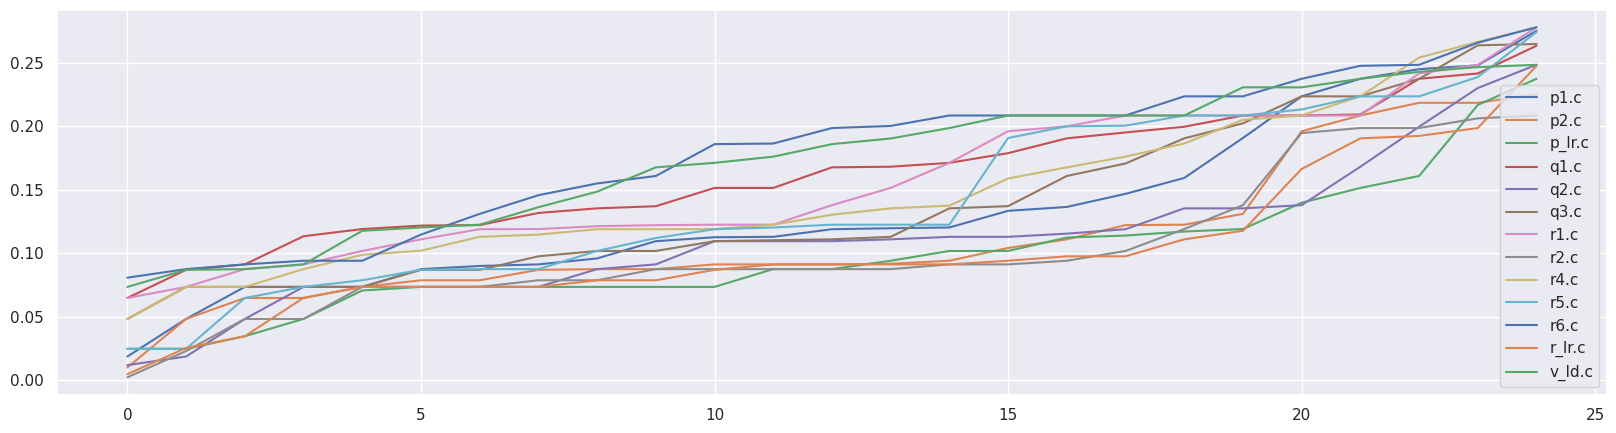

In [24]:
q_val_df.plot()

In [25]:
first_lag = config["cross_correlation_config"]["first_lag"]
last_lag = config["cross_correlation_config"]["last_lag"]
xcorrs = csigproc.compute_mean_cross_correlations(
    regression_df,
    config["feature_col_names"],
    "zrets",
    first_lag,
    last_lag,
)
xcorrs.head()

,p1.c._xcorr_.zrets,p2.c._xcorr_.zrets,p_lr.c._xcorr_.zrets,q1.c._xcorr_.zrets,q2.c._xcorr_.zrets,q3.c._xcorr_.zrets,r1.c._xcorr_.zrets,r2.c._xcorr_.zrets,r4.c._xcorr_.zrets,r5.c._xcorr_.zrets,r6.c._xcorr_.zrets,r_lr.c._xcorr_.zrets,v_ld.c._xcorr_.zrets
1,-0.013704,-0.022324,-0.022865,0.005108,-0.016940,-0.015493,-0.009898,-0.024592,-0.009089,0.015263,-0.000723,-0.024085,0.006619
2,-0.013199,-0.017539,-0.018956,-0.008575,-0.013607,-0.016853,-0.010525,-0.023163,-0.009816,0.022833,0.004243,-0.022883,-0.014058
3,-0.017432,-0.015363,-0.019987,0.004158,-0.021856,-0.017690,-0.015232,-0.015297,-0.012998,0.005992,0.006807,-0.017017,0.004440
4,0.000075,0.000822,0.000507,-0.009327,0.004055,0.005146,0.002695,0.001557,-0.001869,-0.004491,-0.003599,0.001998,0.006379
5,-0.011181,-0.012970,-0.014889,-0.004454,-0.011989,-0.010181,-0.007644,-0.014842,-0.008609,0.009822,0.008923,-0.014948,-0.013869


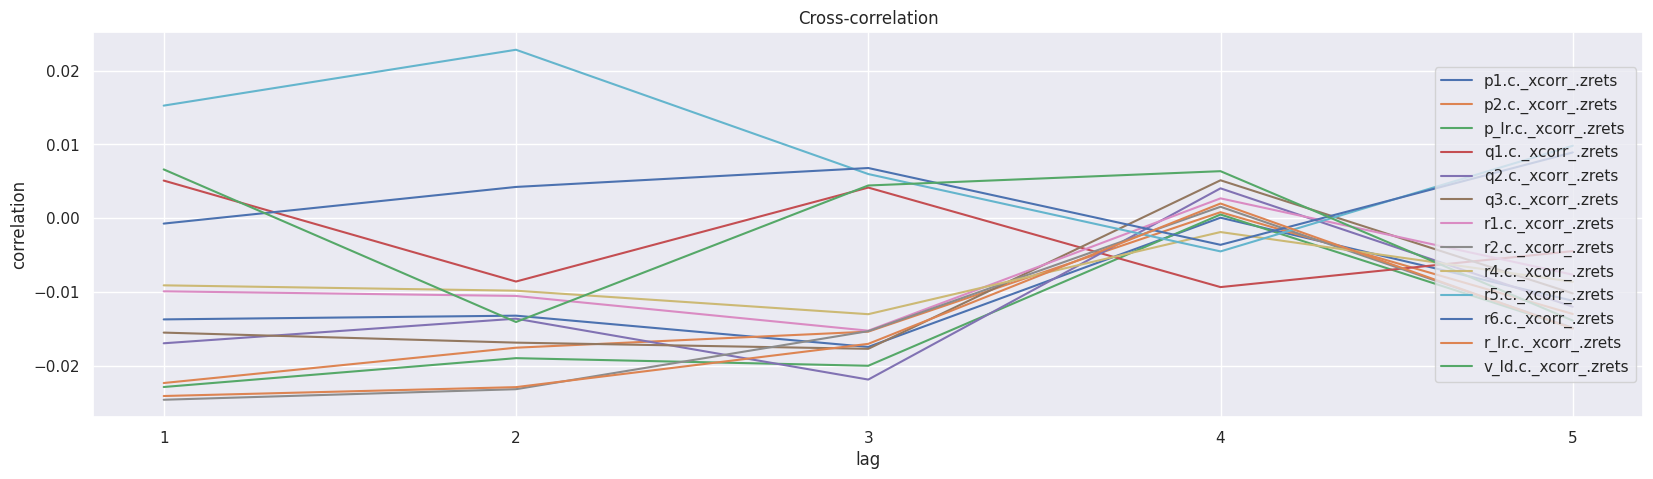

In [26]:
xcorrs.plot(
    title="Cross-correlation",
    xticks=range(first_lag, last_lag + 1),
    xlabel="lag",
    ylabel="correlation",
).legend(loc="right")

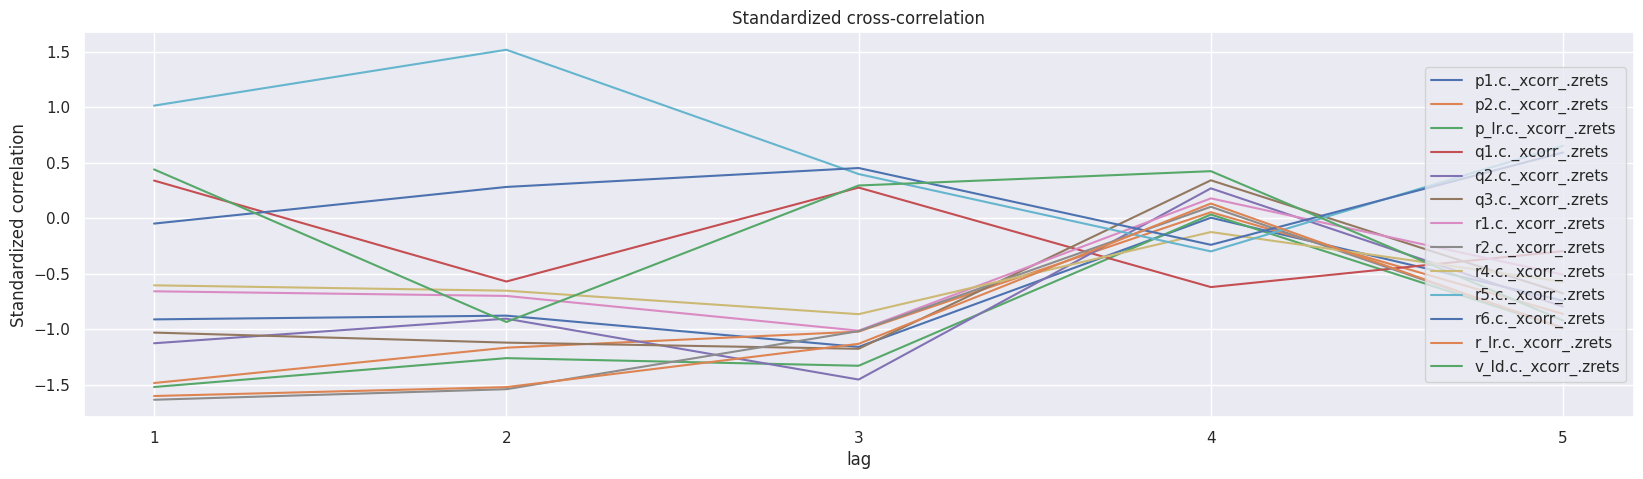

In [27]:
(np.arctanh(xcorrs) * np.sqrt(regression_df.shape[0])).plot(
    title="Standardized cross-correlation",
    xticks=range(first_lag, last_lag + 1),
    xlabel="lag",
    ylabel="Standardized correlation",
).legend(loc="right")